# Triggerによる制御
Triggerによる実行タスクの制御について試す。

タスクを定義する際に、そのタスクが実行されるための条件を設定することができる。これをTriggerという。

Triggerを設定したタスクのupstream taskの状態(e.g. 成功した / 失敗した)に応じて実行を判断する。

例えば、あるタスクAに `all_successful` というTriggerを設定(`@task(trigger=all_successful)`)したとする。タスクAのupstream taskとしてタスクBとタスクCを設定した場合、タスクAが実行されるのはタスクBとタスクCが成功した時のみである。(つまり、タスクBかタスクCのどちらかが失敗したらタスクAは実行されない)

In [1]:
## needs import
from prefect import task, Flow
from prefect.triggers import all_successful, all_failed, any_successful, any_failed, some_successful, some_failed, all_finished, manual_only, not_all_skipped
from prefect.engine.signals import SKIP

## タスクの成功・失敗によるTrigger
- all_successful: 全てのupstream taskが成功した場合に実行される (Triggerを何も指定しない場合、defaultでこれが指定される)
- all_failed: 全てのupstream taskが失敗した場合に実行される
- any_successful: 一つでもupstream taskが成功した場合に実行される
- any_failed: 一つでもupstream taskが失敗した場合に実行される
- some_successful: 成功したupstream taskの数が指定した上限・下限内であれば実行される
- some_failed: 成功したupstream taskの数が指定した上限・下限内であれば実行される

In [2]:
# タスクの定義
@task
def successful_task():
    pass

@task
def failed_task():
    raise Exception("failed_1")

# upstream tasksに設定されたタスクが「全て成功」した場合に実行されるタスク
@task(trigger=all_successful)
def all_successful_task():
    print("⭕️ task: all_successful_task")

# upstream tasksに設定されたタスクが「全て失敗」した場合に実行されるタスク
@task(trigger=all_failed)
def all_failed_task():
    print("❌ task: all_failed_task")

# upstream tasksに設定されたタスクが「一つでも成功」した場合に実行されるタスク
@task(trigger=any_successful)
def any_successful_task():
    print("⭕️　task: any_successful_task")

# upstream tasksに設定されたタスクが「一つでも失敗」した場合に実行されるタスク
@task(trigger=any_failed)
def any_failed_task():
    print("❌　task: any_failed_task")

# upstream tasksに設定されたタスクの「成功数が指定した上限(2以下)・下限(1以上)内」である場合に実行されるタスク
@task(trigger=some_successful(at_least=1, at_most=2))
def some_successful_task():
    print("⭕️　task: some_successful_task")

# upstream tasksに設定されたタスクの「失敗数が指定した上限(2以下)・下限(1以上)内」である場合に実行されるタスク
@task(trigger=some_failed(at_least=1, at_most=2))
def some_failed_task():
    print("❌　task: some_failed_task")

🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_all_successful
[2021-09-18 19:19:46+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'all_successful'
[2021-09-18 19:19:46+0900] INFO - prefect.TaskRunner | Task 'successful_task': Starting task run...
[2021-09-18 19:19:46+0900] INFO - prefect.TaskRunner | Task 'successful_task': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:46+0900] INFO - prefect.TaskRunner | Task 'successful_task': Starting task run...
[2021-09-18 19:19:46+0900] INFO - prefect.TaskRunner | Task 'successful_task': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:46+0900] INFO - prefect.TaskRunner | Task 'successful_task': Starting task run...
[2021-09-18 19:19:46+0900] INFO - prefect.TaskRunner | Task 'successful_task': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:46+0900] INFO - prefect.TaskRunner | Task 'any_failed_task': Starting task run...
[2021-09-18 19:19:46+0900] INFO - prefect.TaskRunner | Task 'any_

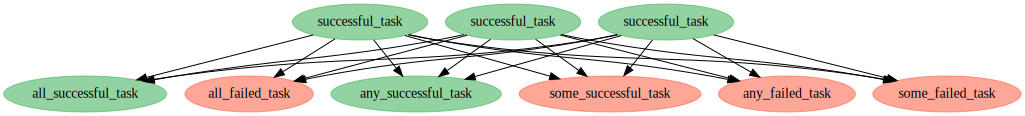

In [3]:
# 全てのupstream taskが成功する場合のFlow
with Flow("all_successful") as flow_all_successful:
    s1 = successful_task()
    s2 = successful_task()
    s3 = successful_task()
    upstream_tasks = [s1, s2, s3]
    all_s = all_successful_task(upstream_tasks=upstream_tasks)
    all_f = all_failed_task(upstream_tasks=upstream_tasks)
    any_s = any_successful_task(upstream_tasks=upstream_tasks)
    any_f = any_failed_task(upstream_tasks=upstream_tasks)
    some_s = some_successful_task(upstream_tasks=upstream_tasks)
    some_f = some_failed_task(upstream_tasks=upstream_tasks)

print("🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_all_successful")
flow_all_successful_state = flow_all_successful.run()
flow_all_successful.visualize(flow_state=flow_all_successful_state)


 🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_all_failed
[2021-09-18 19:19:46+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'all_failed'
[2021-09-18 19:19:46+0900] INFO - prefect.TaskRunner | Task 'failed_task': Starting task run...
[2021-09-18 19:19:46+0900] ERROR - prefect.TaskRunner | Task 'failed_task': Exception encountered during task execution!
Traceback (most recent call last):
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/prefect/engine/task_runner.py", line 859, in get_task_run_state
    value = prefect.utilities.executors.run_task_with_timeout(
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/prefect/utilities/executors.py", line 445, in run_task_with_timeout
    return task.run(*args, **kwargs)  # type: ignore
  File "/var/folders/6b/t3v4fdjs7gq6j0rw2gcb0s7r0000gn/T/ipykernel_75086/3956158869.py", line 8, in failed_task
    raise Exception("failed_1")
Exc

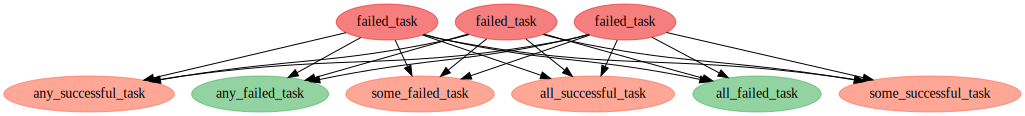

In [4]:
# 全てのupstream taskが失敗する場合のFlow
with Flow("all_failed") as flow_all_failed:
    f1 = failed_task()
    f2 = failed_task()
    f3 = failed_task()
    upstream_tasks = [f1, f2 ,f3]
    all_s = all_successful_task(upstream_tasks=upstream_tasks)
    all_f = all_failed_task(upstream_tasks=upstream_tasks)
    any_s = any_successful_task(upstream_tasks=upstream_tasks)
    any_f = any_failed_task(upstream_tasks=upstream_tasks)
    some_s = some_successful_task(upstream_tasks=upstream_tasks)
    some_f = some_failed_task(upstream_tasks=upstream_tasks)

print("\n", "🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_all_failed")
flow_all_failed_state = flow_all_failed.run()
flow_all_failed.visualize(flow_state=flow_all_failed_state)

🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_one_successful_one_failed
[2021-09-18 19:19:47+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'one_successful_one_failed'
[2021-09-18 19:19:47+0900] INFO - prefect.TaskRunner | Task 'failed_task': Starting task run...
[2021-09-18 19:19:47+0900] ERROR - prefect.TaskRunner | Task 'failed_task': Exception encountered during task execution!
Traceback (most recent call last):
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/prefect/engine/task_runner.py", line 859, in get_task_run_state
    value = prefect.utilities.executors.run_task_with_timeout(
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/prefect/utilities/executors.py", line 445, in run_task_with_timeout
    return task.run(*args, **kwargs)  # type: ignore
  File "/var/folders/6b/t3v4fdjs7gq6j0rw2gcb0s7r0000gn/T/ipykernel_75086/3956158869.py", line 8, in failed_task
    rai

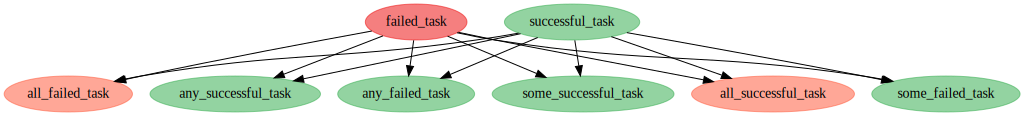

In [5]:
# upstream taskの1つが成功し1つが失敗する場合のFlow
with Flow("one_successful_one_failed") as flow_one_successful_one_failed:
    s1 = successful_task()
    f1 = failed_task()
    upstream_tasks = [s1, f1]
    all_s = all_successful_task(upstream_tasks=upstream_tasks)
    all_f = all_failed_task(upstream_tasks=upstream_tasks)
    any_s = any_successful_task(upstream_tasks=upstream_tasks)
    any_f = any_failed_task(upstream_tasks=upstream_tasks)
    some_s = some_successful_task(upstream_tasks=upstream_tasks)
    some_f = some_failed_task(upstream_tasks=upstream_tasks)

print("🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_one_successful_one_failed")
flow_one_successful_one_failed_state = flow_one_successful_one_failed.run()
flow_one_successful_one_failed.visualize(flow_state=flow_one_successful_one_failed_state)

🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_two_successful_three_failed
[2021-09-18 19:19:48+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'two_successful_three_failed'
[2021-09-18 19:19:48+0900] INFO - prefect.TaskRunner | Task 'failed_task': Starting task run...
[2021-09-18 19:19:48+0900] ERROR - prefect.TaskRunner | Task 'failed_task': Exception encountered during task execution!
Traceback (most recent call last):
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/prefect/engine/task_runner.py", line 859, in get_task_run_state
    value = prefect.utilities.executors.run_task_with_timeout(
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/prefect/utilities/executors.py", line 445, in run_task_with_timeout
    return task.run(*args, **kwargs)  # type: ignore
  File "/var/folders/6b/t3v4fdjs7gq6j0rw2gcb0s7r0000gn/T/ipykernel_75086/3956158869.py", line 8, in failed_task
   

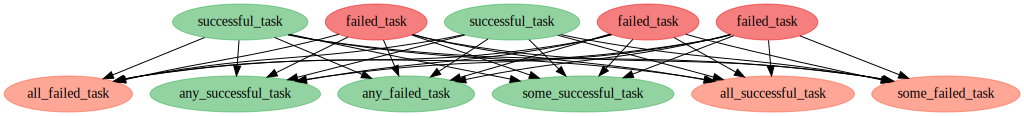

In [6]:
# upstream taskの2つが成功し3つが失敗する場合のFlow
with Flow("two_successful_three_failed") as flow_two_successful_three_failed:
    s1 = successful_task()
    s2 = successful_task()
    f1 = failed_task()
    f2 = failed_task()
    f3 = failed_task()
    upstream_tasks = [s1, s2, f1, f2, f3]
    all_s = all_successful_task(upstream_tasks=upstream_tasks)
    all_f = all_failed_task(upstream_tasks=upstream_tasks)
    any_s = any_successful_task(upstream_tasks=upstream_tasks)
    any_f = any_failed_task(upstream_tasks=upstream_tasks)
    some_s = some_successful_task(upstream_tasks=upstream_tasks)
    some_f = some_failed_task(upstream_tasks=upstream_tasks)

print("🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_two_successful_three_failed")
flow_two_successful_three_failed_state = flow_two_successful_three_failed.run()
flow_two_successful_three_failed.visualize(flow_state=flow_two_successful_three_failed_state)

🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_three_successful_two_failed
[2021-09-18 19:19:49+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'three_successful_two_failed'
[2021-09-18 19:19:49+0900] INFO - prefect.TaskRunner | Task 'successful_task': Starting task run...
[2021-09-18 19:19:49+0900] INFO - prefect.TaskRunner | Task 'successful_task': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:49+0900] INFO - prefect.TaskRunner | Task 'failed_task': Starting task run...
[2021-09-18 19:19:49+0900] ERROR - prefect.TaskRunner | Task 'failed_task': Exception encountered during task execution!
Traceback (most recent call last):
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/prefect/engine/task_runner.py", line 859, in get_task_run_state
    value = prefect.utilities.executors.run_task_with_timeout(
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/pr

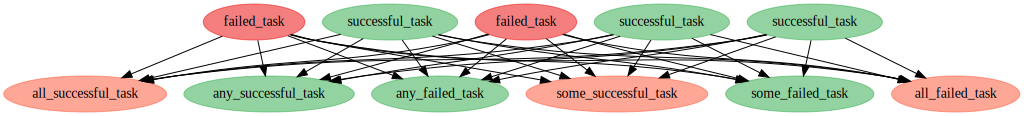

In [7]:
# upstream taskの3つが成功し2つが失敗する場合のFlow
with Flow("three_successful_two_failed") as three_successful_two_failed:
    s1 = successful_task()
    s2 = successful_task()
    s3 = successful_task()
    f1 = failed_task()
    f2 = failed_task()
    upstream_tasks = [s1, s2, s3, f1, f2]
    all_s = all_successful_task(upstream_tasks=upstream_tasks)
    all_f = all_failed_task(upstream_tasks=upstream_tasks)
    any_s = any_successful_task(upstream_tasks=upstream_tasks)
    any_f = any_failed_task(upstream_tasks=upstream_tasks)
    some_s = some_successful_task(upstream_tasks=upstream_tasks)
    some_f = some_failed_task(upstream_tasks=upstream_tasks)

print("🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_three_successful_two_failed")
three_successful_two_failed_state = three_successful_two_failed.run()
three_successful_two_failed.visualize(flow_state=three_successful_two_failed_state)

## その他のTrigger
- all_finished: 成功・失敗は関係なく、全てのupstream taskが完了した場合に実行される
- manual_only:
- not_all_skipped: upstream taskが一つもスキップされておらず全て成功している場合に実行される
  - スキップは`SKIP`シグナルをraiseした場合であり、upstream taskのtirrgerにより実行されなかったもの(`TriggerFailed`)は含まれない

🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_all_finished
[2021-09-18 19:19:50+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'all_finished'
[2021-09-18 19:19:50+0900] INFO - prefect.TaskRunner | Task 'successful_task': Starting task run...
[2021-09-18 19:19:50+0900] INFO - prefect.TaskRunner | Task 'successful_task': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:50+0900] INFO - prefect.TaskRunner | Task 'failed_task': Starting task run...
[2021-09-18 19:19:50+0900] ERROR - prefect.TaskRunner | Task 'failed_task': Exception encountered during task execution!
Traceback (most recent call last):
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/prefect/engine/task_runner.py", line 859, in get_task_run_state
    value = prefect.utilities.executors.run_task_with_timeout(
  File "/Users/ryoasu/Library/Caches/pypoetry/virtualenvs/try-prefect-T2Jmh4JG-py3.9/lib/python3.9/site-packages/prefect/utilities/executors.py",

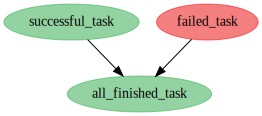

In [8]:
@task(trigger=all_finished)
def all_finished_task():
    print("all_finished_task")

with Flow("all_finished") as flow_all_finished:
    s1 = successful_task()
    f1 = failed_task()
    # all_finished_taskは、upstream_tasksに指定したタスクが完了すれば実行される
    all_finished_task(upstream_tasks=[s1, f1])

print("🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_all_finished")
flow_all_finished_state = flow_all_finished.run()
flow_all_finished.visualize(flow_state=flow_all_finished_state)

🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_one_successful
[2021-09-18 19:19:51+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'manual_only'
[2021-09-18 19:19:51+0900] INFO - prefect.TaskRunner | Task 'successful_task': Starting task run...
[2021-09-18 19:19:51+0900] INFO - prefect.TaskRunner | Task 'successful_task': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:51+0900] INFO - prefect.TaskRunner | Task 'manual_only_task': Starting task run...
[2021-09-18 19:19:51+0900] INFO - prefect.TaskRunner | Task 'manual_only_task': Finished task run for task with final state: 'Paused'
[2021-09-18 19:19:51+0900] INFO - prefect.FlowRunner | Flow run RUNNING: terminal tasks are incomplete.
[2021-09-18 19:19:54+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'manual_only'
[2021-09-18 19:19:54+0900] INFO - prefect.TaskRunner | Task 'manual_only_task': Starting task run...
manual_only
[2021-09-18 19:19:54+0900] INFO - prefect.TaskRunner | Task 'manual_only_task': Finished tas

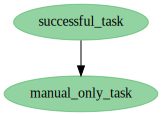

In [9]:
@task(trigger=manual_only)
def manual_only_task():
    print("manual_only")

with Flow("manual_only") as flow_manual_only:
    s1 = successful_task()
    # manual_only_taskは、upstream_tasksに指定したタスクが完了した後に実行するかどうかをmanualで要求する
    manual_only_task(upstream_tasks=[s1])

print("🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_one_successful")
flow_manual_only_state = flow_manual_only.run()
flow_manual_only.visualize(flow_state=flow_manual_only_state)

In [10]:
@task(trigger=not_all_skipped)
def not_all_skipped_task():
    print("not_all_skipped")

@task
def skipped_task():
    raise SKIP("skipped_task")

🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_one_skiped
[2021-09-18 19:19:54+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'one_skiped'
[2021-09-18 19:19:54+0900] INFO - prefect.TaskRunner | Task 'successful_task': Starting task run...
[2021-09-18 19:19:54+0900] INFO - prefect.TaskRunner | Task 'successful_task': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:54+0900] INFO - prefect.TaskRunner | Task 'skipped_task': Starting task run...
[2021-09-18 19:19:54+0900] INFO - prefect.TaskRunner | SKIP signal raised: SKIP('skipped_task')
[2021-09-18 19:19:54+0900] INFO - prefect.TaskRunner | Task 'skipped_task': Finished task run for task with final state: 'Skipped'
[2021-09-18 19:19:54+0900] INFO - prefect.TaskRunner | Task 'not_all_skipped_task': Starting task run...
[2021-09-18 19:19:54+0900] INFO - prefect.TaskRunner | Task 'not_all_skipped_task': Finished task run for task with final state: 'Skipped'
[2021-09-18 19:19:54+0900] INFO - prefect.FlowRunner | Flow run SUCCESS: 

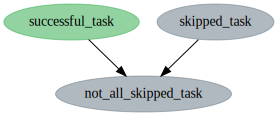

In [11]:
with Flow("one_skiped") as flow_one_skiped:
    s1 = successful_task()
    # スキップされるタスク
    skipped_1 = skipped_task()
    # スキップされるタスクがupstream_tasksに含まれているので実行されない(このタスクもスキップされる)
    not_all_skipped_task(upstream_tasks=[s1, skipped_1])

print("🏃‍♂️💨💨💨💨💨💨💨💨 RUN: flow_one_skiped")
flow_one_skiped_state = flow_one_skiped.run()
flow_one_skiped.visualize(flow_state=flow_one_skiped_state)